# HW3: Sentiment Analysis via Deep Neural Networks

This homework consists of two parts:

1. You will implement recurrent neural network (RNN), long short-term memory (LSTM), and multi-head attention from scratch, and compare the results with `torch.nn` modules.
2. You will build a text encoder based on the implemented modules and train it on the sentiment analysis task of the movie review dataset(IMDb). Then, evaluate the training results.

You may be asked to complete several functions and classes in `HW_YourAnswer_modules.py` and `HW_YourAnswer_encoders.py`.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Intro_dl/hw3')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Intro_dl/hw3')

Mounted at /content/drive


In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

from utils import normal

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercise 1: DNN Models for Sequential Data

In the first exercise, you will attempt to implement deep neural network models designed for processing sequential data.

## 1.1. Recurrent Neural Network(RNN)

First, let's implement a multi-layer RNN, and then compare it with `torch.nn.RNN`. To do this, we will proceed in two steps.

1. Develop the `OneLayerRNN` module to represent a single-layer RNN.
2. Utilize the `OneLayerRNN` module implemented in step 1 to construct the `MultiLayerRNN` module, enabling the computation of a multi-layer RNN.

In this exercise, it is ***strongly*** recommended to refer to [1] for further details.

[1] https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

### 1.1.1. One Layer RNN

One-layer RNN aims to compute the hidden state for each token when given an input sequence. The formula for this is as follows:

$$
h_t = \text{activation}(W_{ih}x_t+ b_{ih} + W_{hh}h_{t-1} + b_{hh})
$$


The operation of linear projection and adding bias here can be achieved by using the `nn.Linear` module, which was employed in the previous assignment.


### To Do:
- Implement `OneLayerRNN` class in `HW_YourAnswer_modules.py` file.

In order to compute a multi-layer RNN in the future, it is necessary to return not only the final hidden state required for classification but also all hidden states corresponding to the entire input sequence. For detailed instructions, refer to the documentation in the respective file.

The following code directly compares the computational results of your module and the PyTorch built-in module `nn.RNN`. L2 norm is used as the loss function to check for backward passes. More details can be found in `module_check.py`.

In [6]:
from HW_YourAnswer_modules import OneLayerRNN
from module_check import Info, check_one_layer_rnn

# Setting hyperparameters
info = Info(device = DEVICE)

input_size = info.input_size
hidden_size = info.hidden_size


# Implemented one-layer RNN(yours)
one_layer_rnn = OneLayerRNN(input_size = input_size, hidden_size = hidden_size).to(DEVICE)
# RNN from torch.nn
target_rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first = True).to(DEVICE)

# Function for comparison
check_one_layer_rnn(one_layer_rnn, target_rnn, info)

Model: OneLayerRNN
batch_size: 64
input_size: 128
hidden_size: 128
n_seq: 20

Forward MSE for output layer	: 1.38455e-14
Forward MSE the last h		: 1.37434e-14
Backward MSE			: 1.50610e-15


### Reference: `nn.Sequential`

`torch.nn.Sequential` is a container module that allows you to construct neural networks in a sequential manner. It is a convenient way to sequentially organize a series of layers in a neural network. You can pass a list of layers to torch.nn.Sequential, and it will execute them in the order they are passed. Each layer's output serves as the input to the next layer. This sequential arrangement simplifies the code, making it more readable and easier to manage.


The following example provides a demonstration to aid in understanding the module.

In [7]:
# MLP w/o nn.Sequential
class NaiveNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear0 = nn.Linear(2, 2)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(2, 1)

    def forward(self, x):
        out = self.linear0(x)
        out = self.relu(out)
        out = self.linear1(out)
        return out

# MLP w/ nn.Sequential
class SequentialNet(nn.Module):
    def __init__(self):
        super().__init__()
        linear = [nn.Linear(2, 2), nn.Linear(2, 1)]
        self.relu = nn.ReLU()
        self.linear = nn.Sequential(*linear)

    def forward(self, x):
        out = self.linear[0](x)
        out = self.relu(out)
        out = self.linear[1](out)
        return out

naive_net = NaiveNet()
sequential_net = SequentialNet()

# parameter matching
for p1, p2 in zip(naive_net.parameters(), sequential_net.parameters()):
    p2.data = p1.data

x = normal((2,))
print(f"NaiveNet forward result\t\t: {naive_net(x).item():.3f}")
print(f"SequentialNet forward result\t: {sequential_net(x).item():.3f}")

NaiveNet forward result		: 0.536
SequentialNet forward result	: 0.536


### 1.1.2. Multi-Layer RNN

Next, let's implement a module to perform multi-layer RNN operations based on the `OneLayerRNN` we implemented earlier. A multi-layer RNN takes as input the output hidden states of the previous layer at each layer.

$$
h_t^{\ell} = \text{activation}(W_{ih}^{\ell}h_t^{\ell-1} + b_{ih}^{\ell} + W_{hh}^{\ell}h_{t-1}^{\ell} + b_{hh}^{\ell})
$$

You may use `nn.Sequential` to define any number of layers you want. If implemented simply via a list, it will not be stored in the module's buffer and may cause problems with device allocation. For other details, see the instruction in the file.

### To Do:
- Implement `MultiLayerRNN` class in `HW_YourAnswer_modules.py` file.

The following code will compare the forward and backward of `nn.RNN` with the module you implemented.

In [8]:
from HW_YourAnswer_modules import MultiLayerRNN
from module_check import Info, check_multi_layer_rnn

# Setting hyperparameters
info = Info(device = DEVICE)

input_size = info.input_size
hidden_size = info.hidden_size
num_layers = info.num_layers

# Implemented multi-layer RNN(yours)
multi_layer_rnn = MultiLayerRNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers).to(DEVICE)
# RNN from torch.nn
target_rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True).to(DEVICE)

# Function for comparison
check_multi_layer_rnn(multi_layer_rnn, target_rnn, info)

Model: MultiLayerRNN
batch_size: 64
input_size: 128
hidden_size: 128
num_layers: 3
n_seq: 20

Forward MSE for output layer	: 9.45844e-15
Forward MSE the last h		: 1.13324e-14
Backward MSE			: 5.75454e-15


## 1.2: Long Short-Term Memory(LSTM)

Second, let's implement a multi-layer LSTM and compare it to `torch.nn.LSTM`.
1. Develop the `OneLayerLSTM` module to represent a single-layer LSTM
2. Utilize the `OneLayerLSTM` module implemented in step 1 to construct the `MultiLayerLSTM` module, enabling the computation of a multi-layer LSTM.

In this exercise, it is ***strongly*** recommended to refer to [2] for further details.

[2] https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

### 1.2.1. One Layer LSTM

LSTMs are similar to vanilla RNNs in that they output hidden states, but there are differences in the computation process.

$$
\begin{align*}
i_t & = \sigma\left( W_{ii}x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi} \right) \\
f_t & = \sigma\left( W_{if}x_t + b_{if} + W_{hf}h_{t-1} + b_{hf} \right) \\
g_t & = \text{tanh}\left( W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg} \right) \\
o_t & = \sigma\left( W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho} \right) \\
c_t & = f_t \odot c_{t-1} + i_t \odot g_t \\
h_t & = o_t \odot \text{tanh}(c_t)
\end{align*}
$$

If we use the `nn.Linear` module for each gate, we would need a total of 8 modules. However, ***considering that only two types of inputs are used, $x_t$ and $h_{t-1}$, we can see that the linear projection can be computed in parallel by quadrupling the output dimension of the linear projections and then dividing the outputs by four***. Use this fact to implement a one-layer LSTM.

### To Do:
- Implement `OneLayerLSTM` class in `HW_YourAnswer_modules.py` file.

Similar to the implementation of RNNs, LSTMs require hidden state throughout the sequence to implement later multi-layer versions. See the instruction for additional details. The following code will compare the forward and backward of `nn.LSTM` with the module you implemented.

In [9]:
from HW_YourAnswer_modules import OneLayerLSTM
from module_check import Info, check_one_layer_lstm

# Setting hyperparameters
info = Info(device = DEVICE)

input_size = info.input_size
hidden_size = info.hidden_size

# Implemented one-layer LSTM(yours)
one_layer_lstm = OneLayerLSTM(input_size = input_size, hidden_size = hidden_size).to(DEVICE)
# LSTM from torch.nn
target_lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True).to(DEVICE)

# Function for comparision
check_one_layer_lstm(one_layer_lstm, target_lstm, info)

Model: OneLayerLSTM
batch_size: 64
input_size: 128
hidden_size: 128
n_seq: 20

Forward MSE for output layer	: 1.19844e-15
Forward MSE the last h		: 1.17600e-15
Forward MSE the last c		: 4.28841e-15
Backward MSE			: 6.45085e-16


### 1.2.2. Multi-Layer LSTM

Let's implement a module to perform multi-layer LSTM operations based on the `OneLayerLSTM` you implemented earlier. Similar to RNNs, a multi-layer LSTM takes as input the output hidden states of the previous layer at each layer.

### To Do:
- Implement `MultiLayerLSTM` class in `HW_YourAnswer_modules.py` file.

The following code will compare the forward and backward of `nn.LSTM` with the module you implemented.

In [10]:
from HW_YourAnswer_modules import MultiLayerLSTM
from module_check import Info, check_multi_layer_lstm

# Dataset
info = Info(device = DEVICE)

input_size = info.input_size
hidden_size = info.hidden_size
num_layers = info.num_layers

# Implemented multi-layer LSTM(yours)
multi_layer_lstm = MultiLayerLSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers).to(DEVICE)
# LSTM from torch.nn
target_lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True).to(DEVICE)

# Function for comparision
check_multi_layer_lstm(multi_layer_lstm, target_lstm, info)

Model: MultiLayerLSTM
batch_size: 64
input_size: 128
hidden_size: 128
num_layers: 3
n_seq: 20

Forward MSE for output layer	: 1.37404e-16
Forward MSE the last h		: 4.18566e-16
Forward MSE the last c		: 1.58943e-15
Backward MSE			: 9.80904e-16


## 1.3: Multi-head Attention

Next, let's implement a module to perform multi-head attention and compare it to `torch.nn.MultiheadAttention`. To do this, proceed with the following 3 steps
1. Define a module that linearly projects the query, key, and value vectors before performing the attention operation.
2. Define a function to split the linearly projected query, key, and value into multiple heads
3. Define a function to perform scaled dot-product attention based on the results of 1 and 2, and define a forward function.

In this exercise, it is ***strongly*** recommended to refer to [3] and [4] for further detail.

[3] Vaswani, A., et al, "Attention is All you Need," in *Advances in Neural Information Processing Systems*, 2017.<br>
[4] https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

### 1.3.1. Linear Projections

Scaled dot-product attention is computed in vectorized form by the following process.

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

where $d_k$ is the dimension of the linearly projectionquery, key, and value vectors. Using the above expression, we can describe multi-head attention as follows.

$$
\begin{align*}
\text{Multihead}(Q, K, V) & = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O \\
\text{where head}_i & = \text{Attention}(QW_i^Q, KW_i^K, WV_i^V)
\end{align*}
$$

Based on the above expression, we need (3 * $\texttt{num\_heads}$ + 1) linear projections. However, since the projected query and key value required for each head all have the same input, we can simplify the calculation by using only one projection for each and then dividing the result by $\texttt{num\_heads}$. Thus, a total of four linear projections are required for multi-head attention. Before we start implementing the attention mechanism, let's define the projection modules.

### To Do:
- Implement the `__init__` function of the `MultiheadAttention` class inside the `HW_YourAnswer_modules.py` file.

You can see what submodules the `MultiheadAttention` module you implemented has in the code block below.

Note: The `nn.MultiheadAttention` module which we target uses a trainable bias initialized with a zero vector for both input and output projection. Therefore, there is no need to use the ($\texttt{bias = False}$) argument when using the `nn.Linear` module.

If implemented correctly, the output from running the code block below should look like this.

```
MultiheadAttention(
  (q_proj): Linear(in_features=6, out_features=6, bias=True)
  (k_proj): Linear(in_features=3, out_features=6, bias=True)
  (v_proj): Linear(in_features=3, out_features=6, bias=True)
  (out_proj): Linear(in_features=6, out_features=6, bias=True)
)
```

In [11]:
from HW_YourAnswer_modules import MultiheadAttention
from module_check import Info

# Setting hyperparameters
info = Info(
    device = DEVICE,
    batch_size = 1,
    n_seq = 2,
    embed_dim = 6,
    num_heads = 3,
    kdim = 3,
    vdim = 3
)

embed_dim = info.embed_dim
num_heads = info.num_heads
kdim = info.kdim
vdim = info.vdim

# Initialized multi-head attention module(yours)
my_attention = MultiheadAttention(
    embed_dim = embed_dim,
    num_heads = num_heads,
    kdim = kdim,
    vdim = vdim
    ).to(DEVICE)

print(my_attention)

MultiheadAttention(
  (q_proj): Linear(in_features=6, out_features=6, bias=True)
  (k_proj): Linear(in_features=3, out_features=6, bias=True)
  (v_proj): Linear(in_features=3, out_features=6, bias=True)
  (out_proj): Linear(in_features=6, out_features=6, bias=True)
)


### 1.3.2. Head Splitting

In order to perform Attention in a multi-head manner, we need to divide the input query, key, and value by the number of heads. To put this in terms of tensor size, a tensor with the shape $\texttt{(batch\_size, n\_seq, embed\_dim)}$ should be replaced with $\texttt{(batch\_size, num\_heads, n\_seq, embed\_dim // num\_heads)}$. The position of each dimension is to simplify the attention process later on.

### To Do:
- Implement the `split_heads` function of the `MultiheadAttention` class inside the `HW_YourAnswer_modules.py` file.

Suppose the arguments required for execution are defined as follows:
```
batch_size = 1
n_seq = 2
embed_dim = 6
num_heads = 3
```
If implemented correctly, the output from running the code block below should look like this

```
Original Tensor
shape: torch.Size([1, 2, 6])
[[[ 0  1  2  3  4  5]
  [ 6  7  8  9 10 11]]]

Splitted Tensor
shape: torch.Size([1, 3, 2, 2])
[[[[ 0  1]
   [ 6  7]]

  [[ 2  3]
   [ 8  9]]

  [[ 4  5]
   [10 11]]]]
```

In the result above, you can see that the embedding vector, corresponding to the third dimension of the original tensor, is divided into thirds.

In [12]:
from utils import tensor_print

# You can change the hyperparameters to check your results; default is (1, 2, 6, 3)
batch_size = 1
n_seq = 2
embed_dim = 6
num_heads = 3

my_attention = MultiheadAttention(
    embed_dim = embed_dim,
    num_heads = num_heads,
    kdim = kdim,
    vdim = vdim
    ).to(DEVICE)

x = torch.arange(batch_size * n_seq * embed_dim).reshape((batch_size, n_seq, embed_dim)).to(DEVICE)

print("Original Tensor")
tensor_print(x)
print()

print("Splitted Tensor")
tensor_print(my_attention.split_heads(x))

Original Tensor
shape: torch.Size([1, 2, 6])
[[[ 0  1  2  3  4  5]
  [ 6  7  8  9 10 11]]]

Splitted Tensor
shape: torch.Size([1, 3, 2, 2])
[[[[ 0  1]
   [ 6  7]]

  [[ 2  3]
   [ 8  9]]

  [[ 4  5]
   [10 11]]]]


### Reference: `torch.Tensor.masked_fill`

`Tensor.masked_fill` is a method that allows you to fill elements of a tensor with a specified value based on a provided mask. This method is useful for selectively updating values in a tensor according to a condition specified by the mask.

The following code block is an example of how `Tensor.masked_fill` can be utilized.

In [13]:
# Create a sample tensor
tensor = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Define a mask with the same shape as the tensor
mask = torch.tensor([[True, False, True], [False, True, False], [True, False, True]])

# Use masked_fill to replace values where the mask is True with a specified value, e.g., -1
result = tensor.masked_fill(mask = mask, value = -1)

print("Original Tensor:")
print(tensor)
print("\nMask:")
print(mask)
print("\nResult after masked_fill:")
print(result)

Original Tensor:
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

Mask:
tensor([[ True, False,  True],
        [False,  True, False],
        [ True, False,  True]])

Result after masked_fill:
tensor([[-1,  2, -1],
        [ 4, -1,  6],
        [-1,  8, -1]])


### 1.3.3. Scaled Dot-Product Attention

Now let's complete the module by implementing scaled dot-product attention. The overall procedures can be calculated using the formula provided below.

$$
\begin{align*}
\text{Attention}(Q, K, V) & = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V \\
\text{Multihead}(Q, K, V) & = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O \\
\text{where head}_i & = \text{Attention}(QW_i^Q, KW_i^K, WV_i^V)
\end{align*}
$$

### To Do:
- Implement the `scaled_dot_product_attention` function of the `MultiheadAttention` class inside the `HW_YourAnswer_modules.py` file.
- Implement the `forward` function of the `MultiheadAttention` class inside the `HW_YourAnswer_modules.py` file.

The important thing is to put masking on the padding token before computing the distribution via attention score. ***Masking of the attention score can be accomplished by substituting a very small number (e.g. -1e9) in the position corresponding to the padding token***. For this purpose, it is convenient to use the `Tensor.masked_fill` method. For more details about masking, see the references and instructions in the file.

The following code will compare the forward and backward of `nn.MultiheadAttention` with the module you implemented.

In [14]:
from module_check import Info, check_multi_head_attention

# Setting hyperparameters
info = Info(device = DEVICE)

embed_dim = info.embed_dim
num_heads = info.num_heads
kdim = info.kdim
vdim = info.vdim

# Implemented multi-head attention(yours)
my_attention = MultiheadAttention(embed_dim = embed_dim,
                                  num_heads = num_heads,
                                  kdim = kdim,
                                  vdim = vdim).to(DEVICE)
# Multi-head attention from torch.nn
target_attention = nn.MultiheadAttention(embed_dim = embed_dim,
                                         num_heads = num_heads,
                                         kdim = kdim,
                                         vdim = vdim,
                                         batch_first = True).to(DEVICE)

# Function for comparison
check_multi_head_attention(my_attention, target_attention, info)

Model: MultiheadAttention
batch_size: 64
n_seq: 20
n_key: 10
embed_dim: 128
kdim: 64
vdim: 64
num_heads: 8

Forward MSE for the output: 0.00000e+00
Forward MSE for the attention weights: 0.00000e+00
Backward MSE: 2.31249e-15


# Exercise 2: Sentiment Analysis of IMDb Movie Reviews

In the second exercise, you will use the deep neural networks you implemented earlier to analyze the sentiment of text data.

## 2.1. Data Processing and nn.Embedding

Let's start by fetching the data and then processing it. For the textual data, we use the Large Movie Review Dataset [5]. The Large Movie Review Dataset is a dataset consisting of 50,000 movie reviews from IMDb, a movie information site in the United States, each labeled with a positive or negative label to train a machine on the task of determining whether the sentiment in a sentence is positive or negative.



[5] Maas, A., et al, "Learning Word Vectors for Sentiment Analysis," in *Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies*, 2011, pp. 142–150.

### 2.1.1. Data Loading

Let's download the data first. It may take a while.

In [17]:
# Download data
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -zxf ./aclImdb_v1.tar.gz

You can see samples of the downloaded data in the code below.

In [18]:
import numpy as np
from imdb import Imdb

from train import train
from utils import review_print, model_print, predict

# Dataset
imdb = Imdb()
vocabs = imdb.vocabs
num_tokens = imdb.num_tokens
pos_text = imdb.pos_text
neg_text = imdb.neg_text
print(num_tokens)
# Reviews
rand_idx = np.random.randint(num_tokens)
print(rand_idx)
print("1. Positive review example")
review_print(pos_text[rand_idx])
print("2. Negative review example")
review_print(neg_text[rand_idx])

10004
7448
1. Positive review example
####################################################################################################
More a snapshot of the most popular pinup of all time than your typical dragged out biopic, this fun
 and fabulous film has the look and feel of the era with an excellent soundtrack and everything you 
would want in an indie-type film. I think the tendency would be to portray Bettie Page as some sort 
of sex vixen, like a Jayne Mansfield. But if you've truly looked carefully at Bettie's poses, she al
ways looked happy. Not a "you wish you could get with me" haughty look, nor the "I'm just doing this
 because my acting career didn't work out" look of a porn star. And so, the ladies involved with thi
s film (three female producers, a female writer/ director, female co-writer and the lovely Gretchen 
Mol, who I'm sure helped shape this role with her own sugary influence) really captured the idea of 
a sweet, somewhat naive, southern girl who really enj

### 2.1.2. Text Processing and nn.Embedding

Before text data can be used to train a neural network, several steps of preprocessing are required.

1. Create a dictionary that assigns a token to each word.
2. Make a list of each word in the given text.
3. Assign a token to each word.
4. Assign an embedding to each token.

The IMDb dataset provides a ranking of the frequency of each word, so the dictionary is based on that file. If we process the data in this way, $\texttt{batch\_size}$ text data will be transformed into $\texttt{(batch\_size, n\_seq, embeding\_dim)}$.

### Reference: `torch.nn.Embedding`
`torch.nn.Embedding` is a module that allows you to create an embedding layer for representing discrete tokens as continuous vectors. This layer is often used in natural language processing tasks where words or tokens need to be converted into dense vectors for input to a neural network.

The embedding layer is initialized with the vocabulary size (num_embeddings) and the dimensionality of the embedding vectors (embedding_dim). During the forward pass, this layer takes integer-encoded input indices and returns their corresponding dense vector representations.

The following example demonstrates the initialization and usage of the nn.Embedding layer, with IMDb dataset.

In [19]:
import torch
from torch import nn

from imdb import preprocessing

embedding_dim = 3
embedding = nn.Embedding(num_tokens, embedding_dim)

# Text preprecessing and the tokenizer
tokenizer = imdb.tokenizer
# You can input your own test textual data if interested
test = "This is a testing sentence for HW3!"

print("1. Raw text\t\t:", test)
print("2. After preprocessing\t:", preprocessing(test), f"(length {len(preprocessing(test))})")
print("3. After tokenization\t:", tokenizer(test), f"(length {len(tokenizer(test))})")
embedded = embedding(torch.tensor(tokenizer(test), dtype = torch.int32))
print("4. After Embedding\t:")
print(embedded.detach().numpy(), f"(shape {tuple(embedded.shape)})")

1. Raw text		: This is a testing sentence for HW3!
2. After preprocessing	: ['this', 'is', 'a', 'testing', 'sentence', 'for', 'hw3', '!'] (length 8)
3. After tokenization	: [2, 13, 9, 6, 7619, 4232, 17, 1, 31, 3] (length 10)
4. After Embedding	:
[[ 0.62538606  0.11762935 -0.6436997 ]
 [-0.38054067  1.7439082   0.5117312 ]
 [-0.05690399  0.23697922 -0.37080982]
 [ 0.5303352  -0.9306491  -2.2816625 ]
 [-0.06190388 -0.98336625  0.72788143]
 [ 0.04886209 -0.40684196  1.2292454 ]
 [-0.8301586   1.795873    1.8598481 ]
 [ 1.3332754   1.8470651  -2.2736077 ]
 [ 0.02231281  1.7919348   0.10227925]
 [ 0.04147873  0.50957525 -0.45408133]] (shape (10, 3))


## 2.2: RNN Encoder

Now let's create an encoder using the RNN modules. The most naive encoder structure is to view the last hidden state as a latent vector containing information about the sentence. For this assignment, ***we will build one that applies a binary linear classifier to the last hidden state***. See the instructions in the file for details.

### To Do:
- Implement `RNNEncoder` class in `HW_YourAnswer_encoders.py` file.
- Use `torch.nn.RNN` module to implement the RNN layers

Using your own implementation of `MultiLayerRNN` would be a good exercise. However, unlike the `torch.nn` module, your `MultiLayerRNN` does not have any acceleration techniques and will take a very long time to train. Therefore, ***we recommends using the*** `nn.RNN` ***module to implement*** `RNNEncoder`.

If implemented correctly, `MultiLayerRNN` and `nn.RNN` perform the same operations and produce the same output. However, one caveat is that when using `nn.RNN`, you must force $\texttt{batch\_first = True}$ as an argument. This argument means that the first dimension of the input data corresponds to the batch index.

The next block of code is intended to verify that the implementation is correct by overfitting the model using only 8 data points. Your test accuracy should be 1.00, as the model was trained only on a small dataset.


Test loss:  0.0000| Test accuracy:  1.00



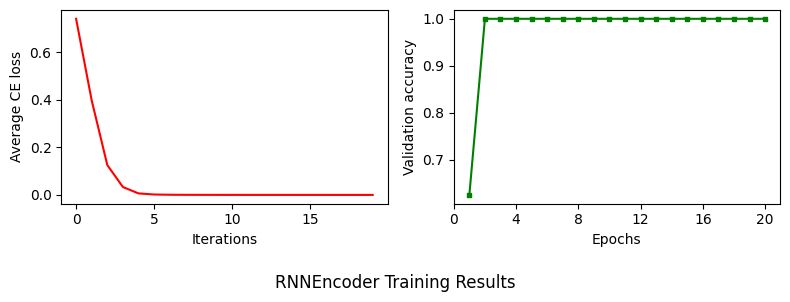

In [20]:
from HW_YourAnswer_encoders import RNNEncoder

# Small dataloader from IMDb dataset; it consists of 20 text data
loaders = imdb.make_small_loaders()

# Hyperparameters
embedding_dim, hidden_dim = 256, 256

# Implemented RNN encoder(yours)
rnn = RNNEncoder(num_tokens = num_tokens,
                 embedding_dim = embedding_dim,
                 hidden_dim = hidden_dim,
                 num_layers = 3).to(DEVICE)

# Function for training
train(rnn, loaders, epochs = 20, lr = 1e-3, small_loader = True)

Once you've completed your sanity check, it's time to try training on full data. If implemented correctly, you should be able to achieve a test accuracy of around 0.7.

### To Do:
- Train your `RNNEncoder` model and report the test accuracy.

You can also see the prediction results of your model.

Epoch 1: 100%|██████████| 235/235 [00:32<00:00,  7.32it/s]


Validation loss:  0.6859| Validation accuracy:  0.55


Epoch 2: 100%|██████████| 235/235 [00:31<00:00,  7.52it/s]


Validation loss:  0.6593| Validation accuracy:  0.61


Epoch 3: 100%|██████████| 235/235 [00:32<00:00,  7.25it/s]


Validation loss:  0.5886| Validation accuracy:  0.69


Epoch 4: 100%|██████████| 235/235 [00:31<00:00,  7.35it/s]


Validation loss:  0.5587| Validation accuracy:  0.72


Epoch 5: 100%|██████████| 235/235 [00:32<00:00,  7.33it/s]


Validation loss:  0.6076| Validation accuracy:  0.67


Epoch 6: 100%|██████████| 235/235 [00:32<00:00,  7.34it/s]


Validation loss:  0.5522| Validation accuracy:  0.72


Epoch 7: 100%|██████████| 235/235 [00:32<00:00,  7.27it/s]


Validation loss:  0.5246| Validation accuracy:  0.75


Epoch 8: 100%|██████████| 235/235 [00:32<00:00,  7.31it/s]


Validation loss:  0.5169| Validation accuracy:  0.75


Epoch 9: 100%|██████████| 235/235 [00:32<00:00,  7.25it/s]


Validation loss:  0.5575| Validation accuracy:  0.72


Epoch 10: 100%|██████████| 235/235 [00:32<00:00,  7.34it/s]


Validation loss:  0.4900| Validation accuracy:  0.77

Test loss:  0.4902| Test accuracy:  0.77



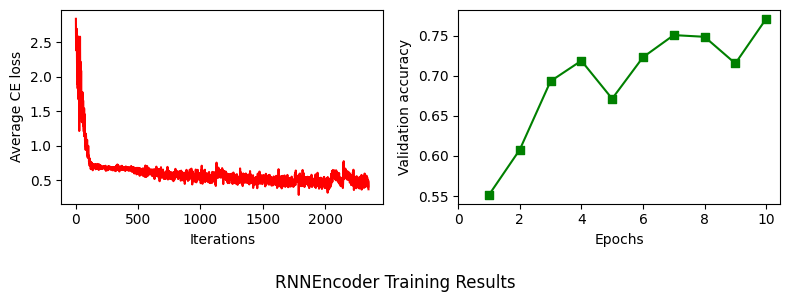

### Sentiment analysis of RNNEncoder model ###

True positive
- Raw text    : This was a wonderful film. How these women tried to save their husbands. I thoug ...
- Model output: [-0.70719296  1.0152291 ]
- True label  : Positive | Model prediction: Positive

False negative
- Raw text    : A stunning film which brought into the open so much about disability that genera ...
- Model output: [ 0.04674812 -0.15810913]
- True label  : Positive | Model prediction: Negative

False positive
- Raw text    : this film has it all; the deft camera work, reminiscent of martin scorcese, or o ...
- Model output: [-0.57767516  0.73049694]
- True label  : Negative | Model prediction: Positive

True negative
- Raw text    : The title leads viewers to believe that this is a fun movie to watch and probabl ...
- Model output: [ 0.36122134 -0.37600142]
- True label  : Negative | Model prediction: Negative



In [21]:
# Full dataloader
loaders = imdb.make_loaders(batch_size = 128)

train(rnn, loaders, epochs = 10, lr = 5e-5)

model_print(rnn, pos_text, neg_text, tokenizer)

Try inserting your own text to see the prediction results if you are interested.

In [22]:
text = "I love this movie"
label = 1
predict(rnn, text, label, tokenizer)

- Raw text    : I love this movie
- Model output: [-0.302907    0.14302155]
- True label  : Positive | Model prediction: Positive



## 2.3: LSTM Encoder

Next, let's create an encoder using an LSTM. Again, using your `MultiLayerLSTM` will require a very long training time, so we recommend using the `nn.LSTM` module. The same as in RNN, you need to force the $\texttt{batch\_first}$ argument to $\texttt{True}$.

### To Do:
- Implement `LSTMEncoder` class in `HW_YourAnswer_encoders.py` file.

The next block of code is intended to verify that the implementation is correct by overfitting the model using only 8 data points. Similarly, the test accuracy should be 1.00.


Test loss:  0.0000| Test accuracy:  1.00



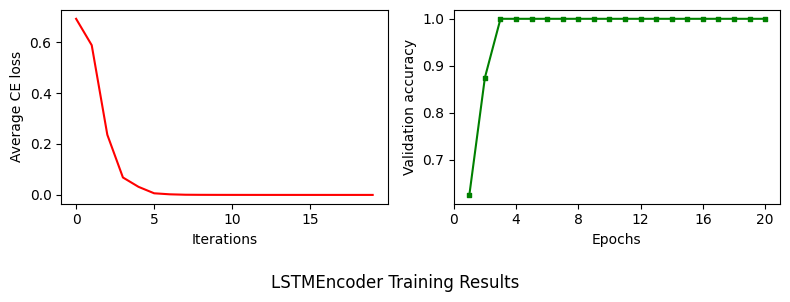

In [25]:
from HW_YourAnswer_encoders import LSTMEncoder

# Small dataloader from IMDb dataset; it consists of 20 text data
loaders = imdb.make_small_loaders()

embedding_dim, hidden_dim = 256, 256

# Implemented LSTM encoder(yours)
lstm = LSTMEncoder(num_tokens = num_tokens,
                 embedding_dim = embedding_dim,
                 hidden_dim = hidden_dim,
                 num_layers = 3).to(DEVICE)

# Function for training
train(lstm, loaders, epochs = 20, lr = 5e-3, small_loader = True)

Try training your `LSTMEncoder` model on full data. If implemented correctly, you should be able to achieve a test accuracy of around 0.8.

### To Do:
- Train your `LSTMEncoder` model and report the test accuracy.

You can also see the prediction results of your model.

Epoch 1: 100%|██████████| 235/235 [01:52<00:00,  2.09it/s]


Validation loss:  0.6938| Validation accuracy:  0.49


Epoch 2: 100%|██████████| 235/235 [01:51<00:00,  2.10it/s]


Validation loss:  0.6923| Validation accuracy:  0.52


Epoch 3: 100%|██████████| 235/235 [01:51<00:00,  2.12it/s]


Validation loss:  0.6892| Validation accuracy:  0.55


Epoch 4: 100%|██████████| 235/235 [01:50<00:00,  2.12it/s]


Validation loss:  0.6820| Validation accuracy:  0.57


Epoch 5: 100%|██████████| 235/235 [01:51<00:00,  2.11it/s]


Validation loss:  0.6514| Validation accuracy:  0.61


Epoch 6: 100%|██████████| 235/235 [01:51<00:00,  2.11it/s]


Validation loss:  0.5442| Validation accuracy:  0.74


Epoch 7: 100%|██████████| 235/235 [01:51<00:00,  2.11it/s]


Validation loss:  0.5050| Validation accuracy:  0.77


Epoch 8: 100%|██████████| 235/235 [01:51<00:00,  2.11it/s]


Validation loss:  0.4894| Validation accuracy:  0.79


Epoch 9: 100%|██████████| 235/235 [01:51<00:00,  2.11it/s]


Validation loss:  0.4309| Validation accuracy:  0.81


Epoch 10: 100%|██████████| 235/235 [01:51<00:00,  2.11it/s]


Validation loss:  0.4866| Validation accuracy:  0.75

Test loss:  0.4473| Test accuracy:  0.80



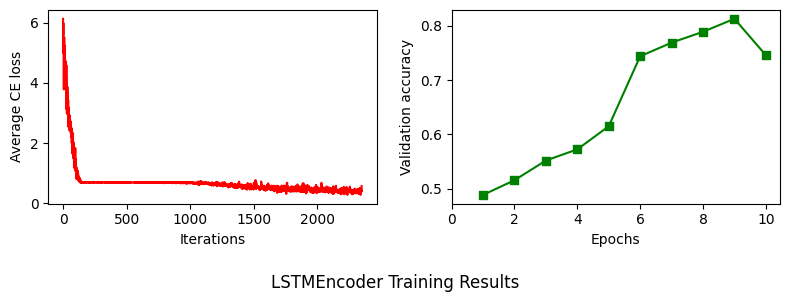

### Sentiment analysis of LSTMEncoder model ###

True positive
- Raw text    : From today's point of view it is quite ridiculous to rate this film 18 (or X in  ...
- Model output: [-1.6407633  1.6992962]
- True label  : Positive | Model prediction: Positive

False negative
- Raw text    : Okay, sure, this movie is a bit on the hokey side. It's difficult to take charac ...
- Model output: [ 0.4840553  -0.49728644]
- True label  : Positive | Model prediction: Negative

True negative
- Raw text    : Everything that made the original so much fun seems to absent here. This is simp ...
- Model output: [ 0.75631946 -0.7155192 ]
- True label  : Negative | Model prediction: Negative

False positive
- Raw text    : I think that you can not imagine how these people really work...!! Before I came ...
- Model output: [-0.92857105  1.0584339 ]
- True label  : Negative | Model prediction: Positive



In [26]:
loaders = imdb.make_loaders(batch_size = 128)
train(lstm, loaders, epochs = 10, lr = 1e-4)

model_print(lstm, pos_text, neg_text, tokenizer)

Try inserting your own text to see the prediction results if you are interested.

In [27]:
text = "I love this movie"
label = 0
predict(lstm, text, label, tokenizer)

- Raw text    : I love this movie
- Model output: [-0.6828618  0.5686841]
- True label  : Negative | Model prediction: Positive



## 2.4: Transformer Encoder

<center><img src="https://drive.google.com/uc?export=download&id=1HhPbR5jzc1DG_8z5yba2v71q95ntEKbP" width="30%"></center>

Finally, let's build an encoder using multi-head attention. In [3], several techniques are added to the encoder in addition to multi-head attention to improve performance. These include

- Positional Encoding
- Layer Normalization (we omit this)
- Feed Forward Network

The original Transformer architecture includes both encoder and decoder layers, but for the purposes of our challenge, we will only implement the encoder.

Again, it is ***strongly*** recommended to refer to [3] for further detail.

[3] Vaswani, A., et al, "Attention is All you Need," in *Advances in Neural Information Processing Systems*, 2017.

### 2.4.1. Feed Forward Network

First, let's implement a feed forward network. A feed forward network consists of two fully connected layers.

### To Do:
- Implement the `FeedForward` class in `HW_YourAnswer_encoders.py`.

See the instruction in the file for details.

### 2.4.2. Positional Encoding

In the Transformer architecture, positional encoding is used to provide the model with information about the positions of elements in the input sequence. Unlike RNN, Transformers don't inherently capture sequential order because they process inputs in parallel. Positional encoding helps the model understand the sequential order of the input by injecting positional information into the input embeddings.

The positional encoding is added to the input embeddings before feeding them into the Transformer model. It is usually a sine and cosine function of different frequencies, which allows the model to differentiate between different positions in the sequence.

Here is the formula for positional encoding:

$$
\begin{align*}
PE_{(pos, 2i)} & = \sin (pos / 10000^\frac{2i}{d_\text{model}}) \\
PE_{(pos, 2i+1)} & = \cos (pos / 10000^\frac{2i}{d_\text{model}})
\end{align*}
$$

### To Do:
- Define `pos_enc` inside `TransformerEncoder.__init__` in the `HW_YourAnswer_encoders.py` file.

One implementation detail is to ***add the singleton dimension beforehand to broadcast for the batch dimension***. See the instruction in the file for details.

If implemented correctly, you should get the following figure when you run the code block below.

<center><img src="https://drive.google.com/uc?export=download&id=1CtkoEv7RmxlampMX7ukY-P9sAK9q_lkN" width="100%"></center>



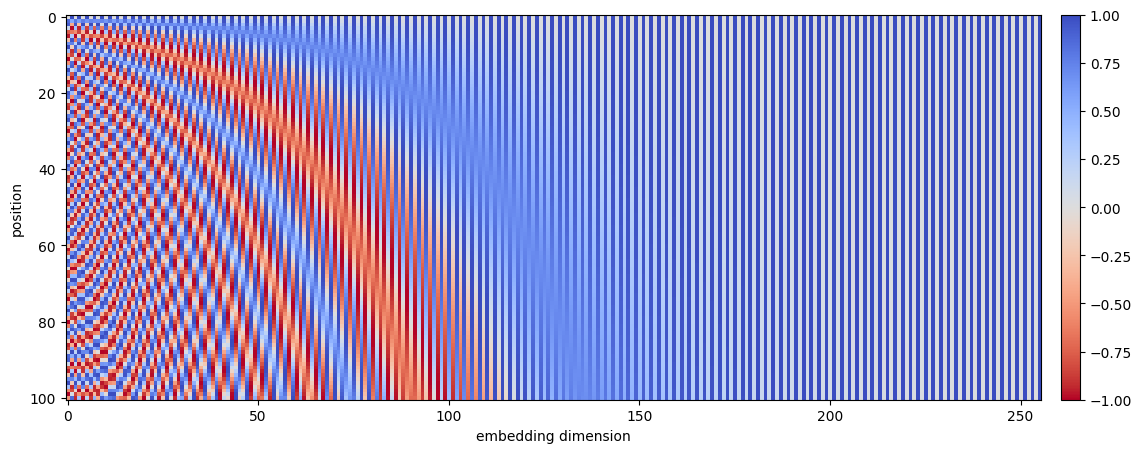

In [28]:
from HW_YourAnswer_encoders import TransformerEncoder
from utils import pos_enc_print

embedding_dim, hidden_dim = 256, 256

# Implemented transformer(yours)
transformer = TransformerEncoder(num_tokens = num_tokens,
                                 embedding_dim = embedding_dim,
                                 hidden_dim = hidden_dim,
                                 num_layers = 1).to(DEVICE)

# Positional encoding
pos_enc = transformer.pos_enc[0, :101, :].cpu().numpy()

pos_enc_print(pos_enc)

### 2.4.3. Forward

Now we are all set to implement the `TransformerEncoder`.

### To Do:
- Implement `EncoderBlock` class in `HW_YourAnswer_encoders.py` file.
- Implement `TransformerEncoder` class in `HW_YourAnswer_encoders.py` file.

The `EncoderBlock` contains one `MultiheadAttention` layer and one `FeedForward` layer. Note that ***you need to do a residual sum after each layer***.

The `TransformerEncoder` is not much different from `RNNEncoder` or `LSTMEncoder` except that it uses `EncoderBlock` as a module to handle recurrence. However, there is a major difference in the position of the padding token \<PAD\> when configuring the dataloader. In the case of RNN and LSTM, the \<EOS\> token that signals the end of the sentence is used as a latent vector, and the \<PAD\> token corresponding to padding is concatenated at the beginning of the sentence to fix the position of the \<EOS\> token. This is because RNNs and LSTMs can convey sequential information well without positional encoding. Conversely, the Transformer cannot adopt this padding strategy since all tokens are simultaneously processed. Therefore, when implementing `TransformerEncoder`, you should use a \<SOS\> token, which indicates the start of the sentence, as a latent vector. This assumes that the padding is concatenated after the sentence.


Test loss:  0.0004| Test accuracy:  1.00



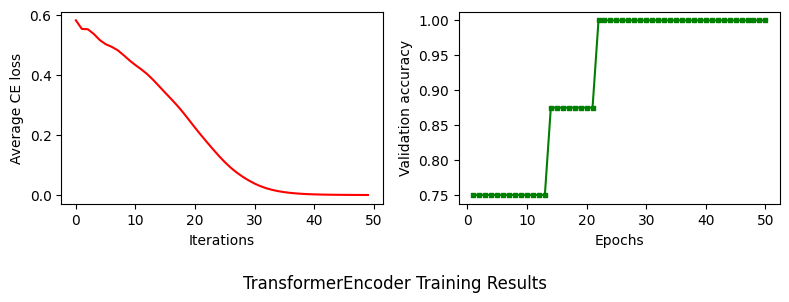

In [29]:
from HW_YourAnswer_encoders import TransformerEncoder

# Small dataloader from the IMDb dataset
loaders = imdb.make_small_loaders(pad_first = False)

embedding_dim, hidden_dim = 256, 256

# Implemented Transformer encoder(yours)
transformer = TransformerEncoder(num_tokens = num_tokens,
                                 embedding_dim = embedding_dim,
                                 hidden_dim = hidden_dim,
                                 num_layers = 1).to(DEVICE)

train(transformer, loaders, epochs = 50, lr = 1e-4, use_mask = True, small_loader = True)

Try training your `TransformerEncoder` model on full data. If implemented correctly, you should be able to achieve a test accuracy of around 0.8.

### To Do:
- Train your `TransformerEncoder` model and report the test accuracy.

You can also see the prediction results of your model.

Epoch 1: 100%|██████████| 3750/3750 [01:07<00:00, 55.95it/s]


Validation loss:  0.4027| Validation accuracy:  0.81


Epoch 2: 100%|██████████| 3750/3750 [01:06<00:00, 56.56it/s]


Validation loss:  0.3621| Validation accuracy:  0.84


Epoch 3: 100%|██████████| 3750/3750 [01:06<00:00, 56.27it/s]


Validation loss:  0.3462| Validation accuracy:  0.85


Epoch 4: 100%|██████████| 3750/3750 [01:06<00:00, 56.53it/s]


Validation loss:  0.3349| Validation accuracy:  0.85


Epoch 5: 100%|██████████| 3750/3750 [01:06<00:00, 56.70it/s]


Validation loss:  0.3237| Validation accuracy:  0.86

Test loss:  0.3233| Test accuracy:  0.86



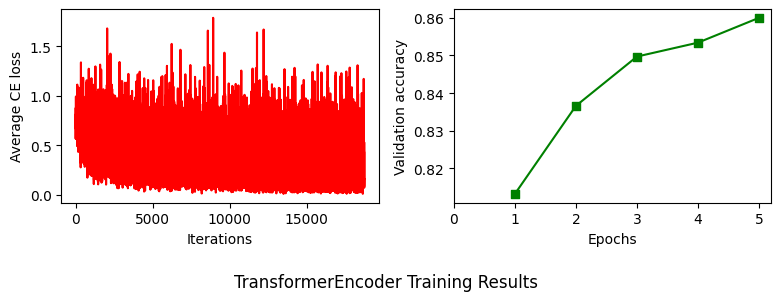

### Sentiment analysis of TransformerEncoder model ###

True positive
- Raw text    : Good: Engaging cinematic firefights, great presentation, vehicles are actually f ...
- Model output: [-1.9408802  1.9275664]
- True label  : Positive | Model prediction: Positive

False negative
- Raw text    : Tomorrow Is Another Day is NOT the sequel to Gone with the Wind but a lovers-on- ...
- Model output: [0.48755306 0.42554125]
- True label  : Positive | Model prediction: Negative

True negative
- Raw text    : Ritchie's first two films were snappy, stylish entertainment. Here, he raids two ...
- Model output: [ 1.188099  -0.4804199]
- True label  : Negative | Model prediction: Negative

False positive
- Raw text    : First off just let me say that I live in South Africa where rugby is our biggest ...
- Model output: [-0.5511883  1.0288345]
- True label  : Negative | Model prediction: Positive



In [30]:
loaders = imdb.make_loaders(batch_size = 8, pad_first = False)
embedding_dim, hidden_dim = 256, 256

transformer = TransformerEncoder(num_tokens = num_tokens,
                                 embedding_dim = embedding_dim,
                                 hidden_dim = hidden_dim,
                                 num_layers = 1)

train(transformer, loaders, epochs = 5, lr = 1e-4, use_mask = True)

model_print(transformer, pos_text, neg_text, tokenizer)

Try inserting your own text to see the prediction results if you are interested.

In [34]:
text = "I love this movie"
label = 1
predict(transformer, text, label, tokenizer)

- Raw text    : I love this movie
- Model output: [-1.9878173  2.1471672]
- True label  : Positive | Model prediction: Positive

